# Understanding Flight Delays for the Top 30 Airports in the USA

## Setup

In [1]:
# For importing our data
from zipfile import ZipFile

# Data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic regression
from statsmodels.tools import tools
from statsmodels.api import Logit

from sklearn.model_selection import KFold

In [2]:
# sklearn's confusion matrix takes 10x longer than this...
def confusion_matrix(y_true, y_pred):
    # Get all values that belong in a category
    def get_category(cat):
        return (y_true == cat[0]) & (y_pred == cat[1])
    
    # The four categories (first coordinate is true, second is predicted)
    categories = [(0, 0), (0, 1), (1, 0), (1, 1)]
    return np.apply_along_axis(get_category, arr=categories, axis=1).sum(axis=1).reshape(2, 2)

In [3]:
# tpr also known as recall
# ppv also known as precision
def classification_scores(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (tn + fp)
    tpr = tp / (tp + fn)
    ppv = tp / (tp + fp)
    f1_score = 2 * (ppv * tpr) / (ppv + tpr)
    return (fpr, tpr, ppv, f1_score)

## Data

In [4]:
# Original weather data needed the weather condition to be decoded
# Done using https://gist.github.com/kfish610/29d0e2874824732ec2d2922f979e4acb
# Due to slowness saved as a csv

# Further minimized using https://gist.github.com/kfish610/48605253428c856bbb1f461c10b6d6ac 

In [5]:
# The original ASPM data (ASPM.zip) contains the hourly count of departures, as well as the percentage of delays
# We have to expand this into individual flights for the logistic regression
# Because we don't have the original flight data, we only have precision down to the hour
# Done using https://gist.github.com/kfish610/b63bbf488d91dcf6877925f7ddfe618b
# This also merges the weather data with the ASPM data, which in Python is too memory inefficient

zipFile = ZipFile('data/ASPM_Transformed.zip')

# Load, but also exclude COVID data
# This also excludes hail, as there are only 41 instances of hail in the whole dataset
df = pd.concat([
        pd.concat(pd.read_csv(
            zipFile.open(f"ASPM{year}.csv"), 
            chunksize=10000,
            usecols=range(1, 9)
        )) for year in range(2015, 2020)
    ])

# Lowercase for consistency
df.columns = df.columns.str.lower()

# Convert to category to save memory
df['facility'] = df['facility'].astype('category')

print(f"{df.shape}")
df.head()

(30081635, 8)


,facility,delayed,air_temp,wind_speed,precipitation,visibility,thunder,snow
0,BOS,0,1.0,4.63,0.0,10.0,0,0
1,FLL,1,22.0,4.63,0.0,10.0,0,0
2,IAD,0,1.0,0.00,0.0,10.0,0,0
3,JFK,0,2.0,2.06,0.0,10.0,0,0
4,JFK,0,2.0,2.06,0.0,10.0,0,0


## Results

### Full Model

First, we run a full logistic regression on our data. Later, we will cross-validate between a couple options, but we want to check if we can fit the data at all first.

In [6]:
endog = df.delayed
exog = tools.add_constant(df.iloc[:, 2:], prepend=True)
full_model = Logit(endog, exog).fit(disp=False)
print(full_model.summary())

                           Logit Regression Results                           
Dep. Variable:                delayed   No. Observations:             30081635
Model:                          Logit   Df Residuals:                 30081628
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Jun 2023   Pseudo R-squ.:                 0.01315
Time:                        16:19:19   Log-Likelihood:            -1.7677e+07
converged:                       True   LL-Null:                   -1.7912e+07
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5567      0.002   -291.502      0.000      -0.560      -0.553
air_temp          0.0009   4.09e-05     20.995      0.000       0.001       0.001
wind_speed        0.0590      0.000    3

Next, we will compare the performance of this model at a range of thresholds, ranging from marking all flights as on time (thresh=1), to the Bayesian classifier (thresh=0.5), to marking all flights as delayed (thresh=0).

In [7]:
thresholds = np.arange(0, 1, 0.05)
scores = np.empty((len(thresholds), 4))

for i, thresh in enumerate(thresholds):
    y_pred = np.where(full_model.predict() > thresh, 1, 0)
    scores[i] = classification_scores(df.delayed, y_pred)

As we can see in the plot below, this model doesn't perform particularly well at prediction; it performs best for the thresholds close to zero, where the model is essentially marking everything as delayed. This is because the recall (percentage of delayed flights that were correctly classified) is 100% there, but takes a sharp slope downward once the model starts classifying flights as on-time, since those are the majority of flights. The sensitivity (percentage of flights classified as delayed that were correctly classified) peaks closer to 75%, but the recall falls off much faster, so this does not affect the F<sub>1</sub> score much.

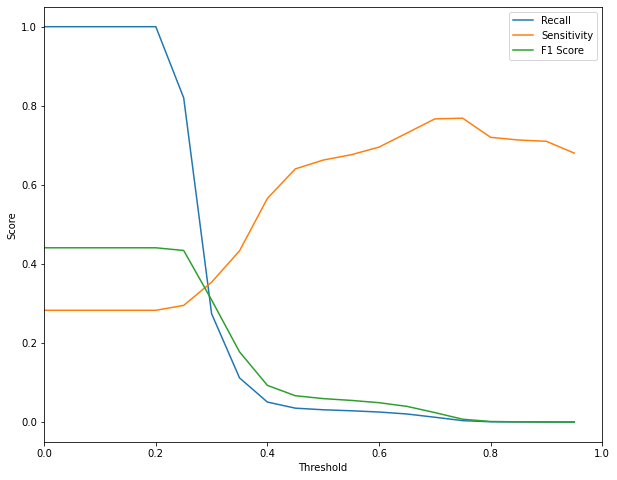

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.lineplot(x=thresholds, y=scores[:, 1], label='Recall')
sns.lineplot(x=thresholds, y=scores[:, 2], label='Sensitivity')
sns.lineplot(x=thresholds, y=scores[:, 3], label='F1 Score')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
plt.xlim((0, 1));

While this model is not good at prediction, it is not necesarilly a faulty model. As we can see in the ROC plot below, while the classification is not ideal, it is consistently above the line of chance (dotted). This, along with the significance of the coefficients in our model, give us confidence that we are capturing real trends in our data with regards to the coefficients, and not just random noise. However, it does indicate that we should not compare across multiple thresholds for cross-validation, since it would result in all the models being identical (with a threshold of 0%).

Text(0, 0.5, 'True Positive Rate')

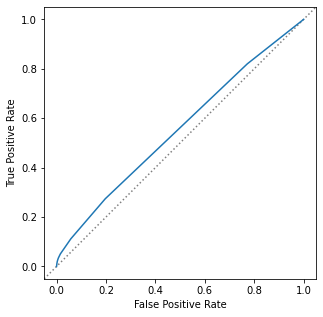

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(x=scores[:, 0], y=scores[:, 1])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]), 
    np.max([ax.get_xlim(), ax.get_ylim()]), 
]

ax.plot(lims, lims, 'k:', alpha=0.5, zorder=0)
ax.set_aspect('equal', 'box')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

### Cross-Validation

Below, we cross-validate three models in order to compare their performance. These are, in order:
1. The full model, with all 6 predictors, plus a constant/bias term.
2. The full model, minus the air temperature. We were unsure why air temperature might affect delays, so this model should help determine to what extend air temperature still affects delays when training and testing data are separated.
3. A model with just our weather variables (thunder, snow, and rain), to see to what extent the behaviors can be explained with just weather.

In [10]:
k_value = 5
kf = KFold(n_splits=k_value, shuffle= True, random_state=18)
full_model_params = np.empty((k_value, 7))
full_model_test_scores = np.empty((k_value, 4))

without_air_model_params = np.empty((k_value, 6))
without_air_model_test_scores = np.empty((k_value, 4))

weather_model_params = np.empty((k_value, 4))
weather_model_test_scores = np.empty((k_value, 4))

for i, (train_index, test_index) in enumerate(kf.split(df.iloc[:, 2:])):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    endog = train_df.delayed
    exog = tools.add_constant(train_df.iloc[:, 2:], prepend=True)
    full_model = Logit(endog, exog).fit(disp=False)
    print("FULL MODEL TRAINED")
    y_pred_train = np.where(full_model.predict(exog) > 0.5, 1, 0)
    y_pred_test = np.where(full_model.predict(tools.add_constant(test_df.iloc[:, 2:], prepend=True)) > 0.5, 1, 0)

    full_model_params[i] = full_model.params
    full_model_test_scores[i] = classification_scores(test_df.delayed, y_pred_test)

    endog = train_df.delayed
    exog = tools.add_constant(train_df.drop(columns = ['air_temp']).iloc[:, 2:], prepend=True)
    without_air_model = Logit(endog, exog).fit(disp = False)
    print("WITHOUT AIR MODEL TRAINED")
    y_pred_train = np.where(without_air_model.predict(exog) > 0.5, 1, 0)
    y_pred_test = np.where(without_air_model.predict(tools.add_constant(test_df.drop(columns = ['air_temp']).iloc[:, 2:], prepend=True)) > 0.5, 1, 0)

    without_air_model_params[i] = without_air_model.params
    without_air_model_test_scores[i] = classification_scores(test_df.delayed, y_pred_test)

    endog = train_df.delayed
    exog = tools.add_constant(train_df[['thunder', 'snow', 'precipitation']], prepend=True)
    weather_model = Logit(endog, exog).fit(disp=False)
    print("WEATHER MODEL TRAINED")
    y_pred_train = np.where(weather_model.predict(exog) > 0.5, 1, 0)
    y_pred_test = np.where(weather_model.predict(tools.add_constant(test_df[['thunder', 'snow', 'precipitation']], prepend=True)) > 0.5, 1, 0)

    weather_model_params[i] = weather_model.params
    weather_model_test_scores[i] = classification_scores(test_df.delayed, y_pred_test)


FULL MODEL TRAINED
WITHOUT AIR MODEL TRAINED
WEATHER MODEL TRAINED
FULL MODEL TRAINED
WITHOUT AIR MODEL TRAINED
WEATHER MODEL TRAINED
FULL MODEL TRAINED
WITHOUT AIR MODEL TRAINED
WEATHER MODEL TRAINED
FULL MODEL TRAINED
WITHOUT AIR MODEL TRAINED
WEATHER MODEL TRAINED
FULL MODEL TRAINED
WITHOUT AIR MODEL TRAINED
WEATHER MODEL TRAINED


In [11]:
print('Average F1 score for full model: ' + str(np.mean(full_model_test_scores[:, 3])))
print('Average F1 score for without air model: ' + str(np.mean(without_air_model_test_scores[:, 3])))
print('Average F1 score for weather model: ' + str(np.mean(weather_model_test_scores[:, 3])))

Average F1 score for full model: 0.059299984350075365
Average F1 score for without air model: 0.059204897484695464
Average F1 score for weather model: 0.058320423161573744


We see here that the full model is indeed the best estimate, though removing air temperature doesn't make much of a difference. The weather only model performs worse than either, though it is still quite close considering it is missing several important predictors. That being said, we turn our focus to the full model now, seeing as how it seems to capture the data most accurately. Below are the best-estimate parameters to this model, taken as the average value. We also compute the variance, and see that it is fairly low, due to the amount of data being processed here.

In [12]:
pd.Series(np.mean(full_model_params, axis = 0), index=np.insert(df.columns[2:], 0, 'intercept'))

intercept       -0.556730
air_temp         0.000859
wind_speed       0.059031
precipitation    0.079664
visibility      -0.070464
thunder          1.073634
snow             1.296216
dtype: float64

In [13]:
pd.Series(np.std(full_model_params, axis = 0), index=np.insert(df.columns[2:], 0, 'intercept'))

intercept        0.000776
air_temp         0.000015
wind_speed       0.000132
precipitation    0.000607
visibility       0.000101
thunder          0.003446
snow             0.001648
dtype: float64

## Additional Data Analysis

Text(0.5, 1.0, 'Number of Flights by Airport (2015-2019)')

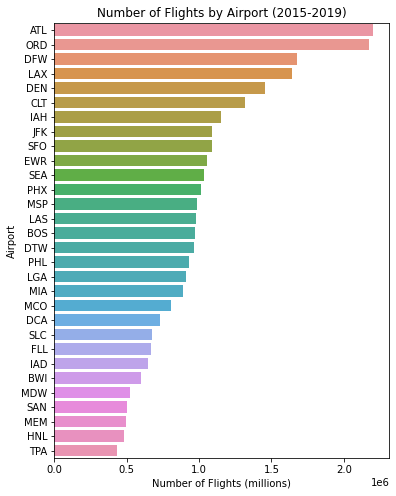

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
sns.countplot(y='facility', data=df, order=df.facility.value_counts().index)
ax.set_xlabel('Number of Flights (millions)')
ax.set_ylabel('Airport')
ax.set_title('Number of Flights by Airport (2015-2019)')

Text(0.5, 1.0, 'Percent Delayed by Airport (2015-2019)')

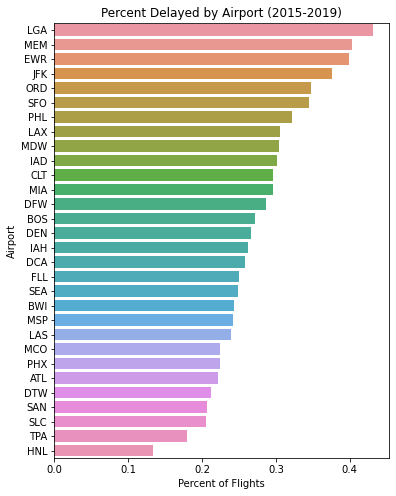

In [15]:
delayRates = df.facility[df.delayed == 1].value_counts() / df.facility.value_counts()
delayDf = pd.DataFrame(delayRates).reset_index().rename(columns={'index': 'facility', 'facility': 'delayRate'})

fig, ax = plt.subplots(1, 1, figsize=(6, 8))
sns.barplot(y='facility', x='delayRate', data=delayDf, order=delayRates.sort_values(ascending=False).index)
ax.set_xlabel('Percent of Flights')
ax.set_ylabel('Airport')
ax.set_title('Percent Delayed by Airport (2015-2019)')

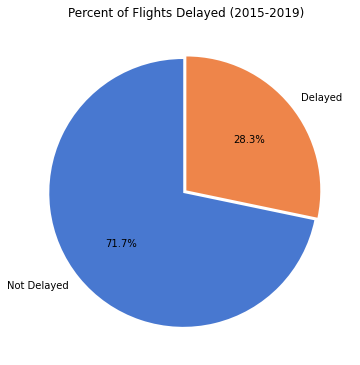

In [16]:
fig,ax = plt.subplots(1, 1, figsize=(6, 8))
plt.pie(df.delayed.value_counts(), labels=['Not Delayed', 'Delayed'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('muted'), explode=(0.03, 0))
fig.set_facecolor('white')
plt.title('Percent of Flights Delayed (2015-2019)');